<a href="https://colab.research.google.com/github/SrijaaimeenakshiM/LLM_from_Scratch/blob/main/LLM_instruction_finetuning_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json

with open("/content/instruction-data.json", 'r') as f:

    data = json.load(f)

In [ ]:
len(data)

1100

In [ ]:
print(data[50])

{'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [ ]:
'''converting input into the format
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'''
#This is known as Alpaca format

In [ ]:
def format_input(input):
    formatted_input = (
        "Below is an instruction that describes a task. Write a response that appropriately completes the request."
        f"\n\n## Instruction:\n{input['instruction']}"
    )

    # Conditionally add input section
    if input['input']:
        formatted_input += f"\n\n## Input:\n{input['input']}"

    formatted_input += f"\n\n## Response:\n{input['output']}"
    return formatted_input


In [ ]:
input=format_input(data[50])
print(input)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

## Instruction:
Identify the correct spelling of the following word.

## Input:
Ocassion

## Response:
The correct spelling is 'Occasion.'


In [ ]:
import torch
from torch.utils.data import Dataset


class Instruction_Dataset(Dataset):
  def __init__(self,data,tokenizer):
    self.data=data
    self.encoded_input=[]

    for i in data:
      full_text=format_input(i)
      self.encoded_input.append(tokenizer.encode(full_text))


  def __getitem__(self,index):
    return self.encoded_input[index]

  def __len__(self):
    return len(self.data)



In [ ]:
#Splitting the train_test data

train_portion=int(0.90*len(data))
test_portion=int(0.10*len(data))

print(train_portion)
print(test_portion)


990
110


In [ ]:
train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]

In [ ]:
#We should add padding to make all the inputs are of same size

def custom_collate_draft(batch,device,pad_token_id=50256):

  max_len=max(len(input)+1 for input in batch)

  inputs=[]

  for input in batch:
    new_input=input.copy()

    new_input+=[pad_token_id]

    padded=(new_input+[pad_token_id]*(max_len-len(new_input)))
    inputs.append(torch.tensor(padded[:-1]))

  input_tensor=torch.stack(inputs).to(device)

  return input_tensor


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft(batch,device))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]], device='cuda:0')


In [ ]:
def custom_collate_draft_2(
    batch,
    device,
    pad_token_id=50256

):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_draft_2(batch,device)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]], device='cuda:0')
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]], device='cuda:0')


In [ ]:
def custom_collate_fn(
    batch,
     device,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None

):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [ ]:
#In PyTorch, when using CrossEntropyLoss (or nn.functional.cross_entropy), any target value equal to -100 is ignored during loss computation.

#-100 means: “Don't compute loss for this token.”

inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_fn(batch,device)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]], device='cuda:0')
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]], device='cuda:0')


In [ ]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [ ]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = Instruction_Dataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)



test_dataset = Instruction_Dataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [ ]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 51]) torch.Size([8, 51])
torch.Size([8, 51]) torch.Size([8, 51])
torch.Size([8, 48]) torch.Size([8, 48])
torch.Size([8, 42]) torch.Size([8, 42])
torch.Size([8, 51]) torch.Size([8, 51])
torch.Size([8, 47]) torch.Size([8, 47])
torch.Size([8, 50]) torch.Size([8, 50])
torch.Size([8, 53]) torch.Size([8, 53])
torch.Size([8, 53]) torch.Size([8, 53])
torch.Size([8, 49]) torch.Size([8, 49])
torch.Size([8, 56]) torch.Size([8, 56])
torch.Size([8, 49]) torch.Size([8, 49])
torch.Size([8, 53]) torch.Size([8, 53])
torch.Size([8, 46]) torch.Size([8, 46])
torch.Size([8, 48]) torch.Size([8, 48])
torch.Size([8, 47]) torch.Size([8, 47])
torch.Size([8, 50]) torch.Size([8, 50])
torch.Size([8, 49]) torch.Size([8, 49])
torch.Size([8, 49]) torch.Size([8, 49])
torch.Size([8, 50]) torch.Size([8, 50])
torch.Size([8, 45]) torch.Size([8, 45])
torch.Size([8, 50]) torch.Size([8, 50])
torch.Size([8, 52]) torch.Size([8, 52])
torch.Size([8, 45]) torch.Size([8, 45])
torch.Size([8, 49]) torch.

In [ ]:
import torch.nn as nn
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [ ]:
import torch.nn as nn
import torch
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768



In [ ]:
#architecture of LLM
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


In [ ]:
from gpt_download3 import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [ ]:
settings,params=download_and_load_gpt2(model_size="355M",models_dir="gpt2")

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 136kiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 570kiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificati

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model,params)
model.to(device)
model.eval();

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

#here we doesn't train we just passing the input to the model and will see what input it gives us

In [ ]:
torch.manual_seed(123)
input_text = format_input(test_data[1])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

## Instruction:
Reword the following sentence to the future tense.

## Input:
He is reading a novel inspired by his grandmother.

## Response:
He will be reading a novel inspired by his grandmother.


In [ ]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer).to(device),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [ ]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

## Output:

He will be reading a novel inspired by his grandmother.

## Example:

He is reading a novel inspired by his grandmother.


#FINETUNING THE LLM ON INSTRUCTION DATA

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches




In [ ]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Testing loss:", test_loss)

Training loss: 3.8503973484039307
Testing loss: 3.780237627029419


In [ ]:
def evaluate_model(gpt, train_loader, test_loader, device, eval_iter):
    gpt.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, gpt, device, num_batches=eval_iter)
        test_loss = calc_loss_loader(test_loader, gpt, device, num_batches=eval_iter)
    gpt.train()
    return train_loss, test_loss

In [ ]:
def train_model_simple(model, train_loader, test_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter):
    # Initialize lists to track losses and tokens seen
    train_losses, test_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, test_loader, device, eval_iter)
                train_losses.append(train_loss)
                test_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")



    return train_losses, test_losses, track_tokens_seen

In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 1

train_losses, test_losses, tokens_seen = train_model_simple(
    model, train_loader, test_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,

)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.552, Val loss 2.537
Ep 1 (Step 000005): Train loss 1.043, Val loss 1.089
Ep 1 (Step 000010): Train loss 0.870, Val loss 0.982
Ep 1 (Step 000015): Train loss 0.803, Val loss 0.916
Ep 1 (Step 000020): Train loss 0.839, Val loss 0.873
Ep 1 (Step 000025): Train loss 0.762, Val loss 0.849
Ep 1 (Step 000030): Train loss 0.676, Val loss 0.824
Ep 1 (Step 000035): Train loss 0.672, Val loss 0.814
Ep 1 (Step 000040): Train loss 0.680, Val loss 0.798
Ep 1 (Step 000045): Train loss 0.634, Val loss 0.785
Ep 1 (Step 000050): Train loss 0.667, Val loss 0.777
Ep 1 (Step 000055): Train loss 0.550, Val loss 0.771
Ep 1 (Step 000060): Train loss 0.601, Val loss 0.767
Ep 1 (Step 000065): Train loss 0.500, Val loss 0.753
Ep 1 (Step 000070): Train loss 0.605, Val loss 0.738
Ep 1 (Step 000075): Train loss 0.544, Val loss 0.738
Ep 1 (Step 000080): Train loss 0.509, Val loss 0.740
Ep 1 (Step 000085): Train loss 0.597, Val loss 0.733
Ep 1 (Step 000090): Train loss 0.472, Val loss

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

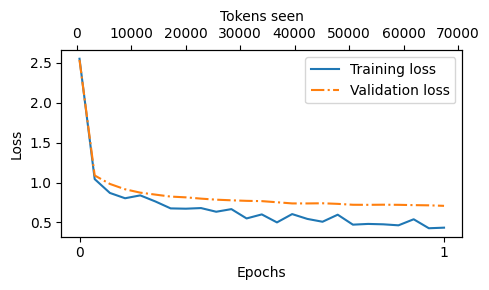

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, test_losses)

In [ ]:
test_examples = [
    {
        "instruction": "Name a synonym for \"happy.\"",
        "output": ">> A synonym for \"happy\" is \"joyful.\""
    },
    {
        "instruction": "What is the capital of Japan?",
        "output": ">> The capital of Japan is Tokyo."
    },
    {
        "instruction": "Convert 10 kilometers to meters.",
        "output": ">> 10 kilometers is 10,000 meters."
    },
    {
        "instruction": "Name a synonym for 'angry.'",
        "input": "",
        "output": "A synonym for \"angry\" is \"furious.\""
    },
    {
        "instruction": "Convert 12 kilometers to meters.",
        "input": "",
        "output": "12 kilometers is 12,000 meters."
    },
    {
        "instruction": "What is the capital of France?",
        "input": "",
        "output": "The capital of France is Paris."
    },
    {
        "instruction": "Reword the following sentence to future tense.",
        "input": "She cooks dinner every night.",
        "output": "She will cook dinner every night."
    },
    {
        "instruction": "Define the term 'photosynthesis'.",
        "input": "",
        "output": "Photosynthesis is the process by which green plants make their own food using sunlight, carbon dioxide, and water."
    },
    {
        "instruction": "Rewrite the sentence using a simile.",
        "input": "He is very strong.",
        "output": "He is as strong as an ox."
    },
    {
        "instruction": "Convert the following sentence to active voice.",
        "input": "The book was read by the teacher.",
        "output": "The teacher read the book."
    },
    {
        "instruction": "What is the past tense of 'swim'?",
        "input": "",
        "output": "The past tense of 'swim' is 'swam'."
    },
    {
        "instruction": "Generate a question based on this statement.",
        "input": "Water boils at 100 degrees Celsius.",
        "output": "What temperature does water boil at?"
    },
    {
        "instruction": "Name the largest planet in our solar system.",
        "input": "",
        "output": "The largest planet in our solar system is Jupiter."
    }
]


In [ ]:
def format_input_text(entry):
    input_text = "Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n"
    input_text += f"### Instruction:\n{entry['instruction']}\n"
    if 'input' in entry and entry['input']:
        input_text += f"\n### Input:\n{entry['input']}\n"
    return input_text


In [ ]:
import torch

torch.manual_seed(123)

# Loop through examples
for entry in test_examples:
    input_text = format_input_text(entry)

    # Generate tokens
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    # Decode text
    generated_text = token_ids_to_text(token_ids, tokenizer)

    # Extract model response only
    response_text = generated_text[len(input_text):].strip()
    for tag in ["### Response:", "## Response:", "Response:", "### Output:", "## Output:", "Output:"]:
        if tag in response_text:
            response_text = response_text.split(tag, 1)[-1].strip()

    # Print results
    print(input_text)
    print(f"\nCorrect response:\n{entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name a synonym for "happy."


Correct response:
>> A synonym for "happy" is "joyful."

Model response:
>> A synonym for "happy" is "joyful."
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the capital of Japan?


Correct response:
>> The capital of Japan is Tokyo.

Model response:
>> The capital of Japan is Tokyo.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert 10 kilometers to meters.


Correct response:
>> 10 kilometers is 10,000 meters.

Model response:
>> 10 kilometers is 1000 meters.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the req

#As we can see based on the test set instructions, given responses, and the model's responses, the model performs relatively well.

**The answers for few question is clearly correct and some are not correct**

# we save the model as gpt2-medium355M-instruction-finetuned.pth file to be able to reuse it in future projects:

In [ ]:
torch.save(model.state_dict(), "gpt2-medium355M-instruction-finetuned.pth")
print(f"Model saved as gpt2-medium355M-instruction-finetuned.pth")

Model saved as gpt2-medium355M-instruction-finetuned.pth
